In [1]:
pip install openseespy opsvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 16.1 MB/s eta 0:00:00


In [2]:
import openseespy.opensees as ops
import opsvis as opsv
import os
import matplotlib.pyplot as plt

In [3]:
ops.wipe()
DataDir = r'Output'
if not os.path.exists(DataDir):
  os.makedirs(DataDir)

In [4]:

# Creating 2D Model
ops.model('Basic', '-ndm', 2, '-ndf', 3)

# Defining problem
numBay = 1
numFloor = 1

# Parameters
L = 30.0 # bay width (in ft)
H = 18.0 # storey height (in ft)
H2 = 14.0 # height to lower chord of truss
l = 5.5 # horizontal truss element length
Lc = 8 # Chord member length
h = 4.0 # vertical member height
F = 10.0 # lateral load magnitude

# Material properties (steel)
E = 29007.6 # ksi
lm = 396.78 # lumped mass (in kips)
Fy = 50.0 # ksi (assumed)

# Section properties
A_col = 86 # in^2
Ix = 14900 # in^4
Iy = 1100 # in^4
A0 = 31.495 # in^2 (Chord-2)
I2 = 132.18 # in^4
A1 = 9.58 # in^2 (Vertical-1)
Iv = 52.0 # in^4
A2 = 14.68 # in^2 (Diagonals)
Id = 117.25 # in^4
A = 17.62 # in^2 (Chord-1/SS/Vertical-SS)
I1 = 34.52 # in^4
Ivs = 206.0 # in^4

# Geometric transformation for force-based elements
ops.geomTransf('PDelta', 1)

ops.beamIntegration('Lobatto', 1, 1, 5)

# Define elastic section IDs for forceBeamColumn usage
ops.section('Elastic', 1, E, A_col, Ix)
ops.section('Elastic', 2, E, A0, I2)
ops.section('Elastic', 3, E, A1, Iv)
ops.section('Elastic', 4, E, A2, Id)
ops.section('Elastic', 5, E, A, I1)
ops.section('Elastic', 6, E, A, Ivs)

# Node coordinates
coords = [
    (10,0,0), (20,L,0), (11,0,H), (21,L,H),
    (110,0,H2), (210,L,H2),
    (111,l,H2), (112,2*l,H2), (113,2*l + Lc,H2), (114,L - l,H2),
    (115,l,H), (116,2*l,H), (117,2*l + Lc,H), (118,L - l,H),
    (30,2*L,0), (31,2*L,H)
]
for tag, x, y in coords:
    ops.node(tag, x, y)

# Boundary conditions
for i in [10,20,30]:
    ops.fix(i,1,1,0)

# Main columns
ops.element('forceBeamColumn', 1, 10, 110, 1, 1, '1')
ops.element('forceBeamColumn', 2, 20, 210, 1, 1, '1')
ops.element('forceBeamColumn', 21, 110, 11, 1, 1, '1')
ops.element('forceBeamColumn', 22, 210, 21, 1, 1, '1')

# Chord-2
ops.element('forceBeamColumn', 3, 110, 111, 1, 1, '2')
ops.element('forceBeamColumn', 4, 114, 210, 1, 1, '2')
ops.element('forceBeamColumn', 5, 11, 115, 1, 1, '2')
ops.element('forceBeamColumn', 6, 118, 21, 1, 1, '2')

# Chord-1
ops.element('forceBeamColumn', 7, 111, 112, 1, 1, '5')
ops.element('forceBeamColumn', 8, 113, 114, 1, 1, '5')
ops.element('forceBeamColumn', 9, 115, 116, 1, 1, '5')
ops.element('forceBeamColumn', 10, 117, 118, 1, 1, '5')

# Vertical-1
ops.element('forceBeamColumn', 11, 111, 115, 1, 1, '3')
ops.element('forceBeamColumn', 12, 114, 118, 1, 1, '3')

# Vertical-SS
ops.element('forceBeamColumn', 13, 112, 116, 1, 1, '6')
ops.element('forceBeamColumn', 14, 113, 117, 1, 1, '6')

# Diagonals
ops.element('forceBeamColumn', 15, 11, 111, 1, 1, '4')
ops.element('forceBeamColumn', 16, 111, 116, 1, 1, '4')
ops.element('forceBeamColumn', 17, 117, 114, 1, 1, '4')
ops.element('forceBeamColumn', 18, 114, 21, 1, 1, '4')

# Chord-SS
ops.element('forceBeamColumn', 19, 112, 113, 1, 1, '5')
ops.element('forceBeamColumn', 20, 116, 117, 1, 1, '5')

# Lean-on column and support
ops.section('Elastic', 7, E, 10*A1, 10*I1)
ops.element('forceBeamColumn', 23, 21, 31, 1, 1, '7')
ops.element('forceBeamColumn', 24, 31, 30, 1, 1, '1')
ops.mass(31, lm, 0.0)
ops.equalDOF(21, 31, 1, 2)

# Loading
ops.timeSeries("Linear", 1)
ops.pattern("Plain", 1, 1)
ops.load(11, 0.0, -F*100, 0.0)


In [5]:
ops.recorder('Node', '-file', 'disp.out', '-time', '-node', 11, 21, 116, 117, '-dof', 1,2, 3, 'disp')
ops.recorder('Element', '-file', 'forces.out', '-time', '-ele', 1, 2, 3, 4, 19, 20, 'force')


1

In [6]:
# Analysis
ops.constraints("Plain")
ops.numberer("RCM")
ops.system("BandGeneral")
ops.test('NormDispIncr', 1.0e-6, 10)
ops.algorithm("Linear")
ops.integrator("LoadControl", 1)
ops.analysis("Static")



# Perform static analysis:
ops.analyze(1)

0

In [7]:
# Get displacement at node 11
ux, uy, rz = ops.nodeDisp(11)
print(f'Displacement at Node 11: ux = {ux:.5f}, uy = {uy:.5f}, rz = {rz:.5f}')

# Example for element tag 1
print('Element forces (global):', ops.eleForce(1))


Displacement at Node 11: ux = -0.00163, uy = -0.00431, rz = 0.00013
Element forces (global): [-140.81323930823493, 732.2378021067551, -2.4554800544673246e-13, 140.81323930823493, -732.2378021067551, 1970.5341242579102]


<Axes: >

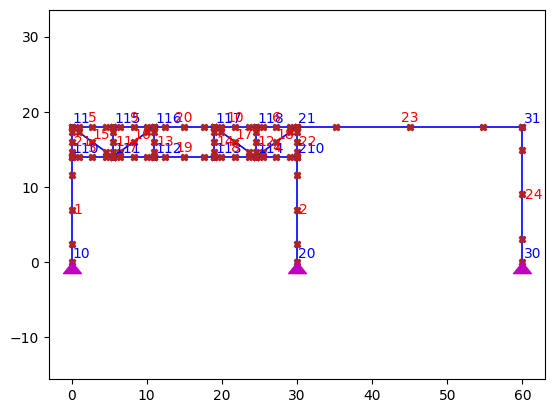

In [8]:
opsv.plot_model()

<Axes: >

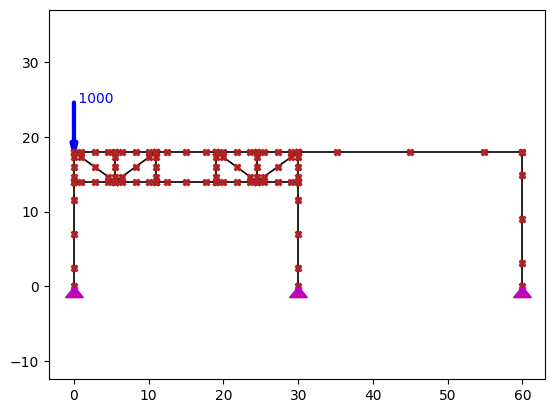

In [9]:
opsv.plot_load()

In [10]:
ops.printModel()

Current Domain Information
	Current Time: 1
	Committed Time: 1
NODE DATA: NumNodes: 16

numComponents: 16

 Node: 10
	Coordinates  : 0 0 
	Disps: 0 0 7.23976e-05 
	 unbalanced Load: 0 0 0 
	ID : -1 -1 39 


 Node: 11
	Coordinates  : 0 18 
	Disps: -0.00162557 -0.00431131 0.0001283 
	 unbalanced Load: 0 -1000 0 
	ID : 33 34 35 


 Node: 20
	Coordinates  : 30 0 
	Disps: 0 0 6.70197e-05 
	 unbalanced Load: 0 0 0 
	ID : -1 -1 1 


 Node: 21
	Coordinates  : 30 18 
	Disps: -0.00127969 -0.000838787 6.86965e-05 
	 unbalanced Load: 0 0 0 
	ID : 6 7 8 


 Node: 30
	Coordinates  : 60 0 
	Disps: 0 0 9.45253e-05 
	 unbalanced Load: 0 0 0 
	ID : -1 -1 0 


 Node: 31
	Coordinates  : 60 18 
	Disps: -0.00127969 -0.000838787 2.42306e-05 
	 unbalanced Load: 0 0 0 
	Mass : 
396.78 0 0 
0 0 0 
0 0 0 

	 Rayleigh Factor: alphaM: 0
	 Rayleigh Forces: 0 0 0 
	ID : 6 7 2 


 Node: 110
	Coordinates  : 0 14 
	Disps: -0.0011625 -0.00410932 0.000104312 
	 unbalanced Load: 0 0 0 
	ID : 36 37 38 


 Node: 111
	Coordi